# Building an AI Pipeline for Image Segmentation and Object Analysis

## 1. Image Segmentation

### Loading The trained model and Pre process the image 

In [1]:
# Loading the required libraries
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Define directories
input_images_dir = 'data/input_images'

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)
model.eval()

# Preprocess image for Mask R-CNN
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (800, 800))
    image = F.to_tensor(image).unsqueeze(0).to(device)
    return image

C:\Users\Rahul\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rahul\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Post-process the image and masks

In [2]:
def postprocess_image(image_tensor):
    image_np = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    image_np = (image_np * 255).astype(np.uint8)
    return image_np

### segmentation of image and visualize

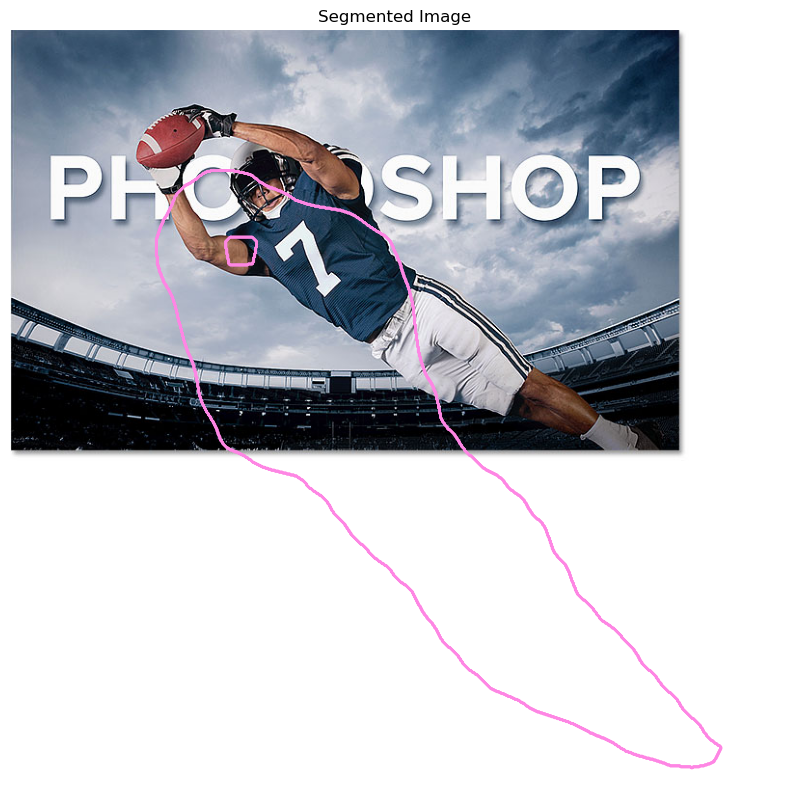

In [3]:
def segment_image(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        prediction = model(image_tensor)
    
    masks = prediction[0]['masks'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image_rgb)
    
    for i in range(len(masks)):
        if scores[i] > 0.5:
            mask = masks[i, 0]
            mask = (mask > 0.5).astype(np.uint8)
            plt.contour(mask, colors=[np.random.rand(3,)])
    
    plt.title('Segmented Image')
    plt.axis('off')
    plt.show()

# Get list of image files
image_files = [f for f in os.listdir(input_images_dir) if os.path.isfile(os.path.join(input_images_dir, f))]

# Segment images
for image_file in image_files:
    image_path = os.path.join(input_images_dir, image_file)
    try:
        segment_image(image_path)
    except Exception as e:
        print(f"Error processing {image_file}: {e}")


Designd incorporate a model to segment objects inside an input image. This involves employing the Mask R-CNN model to segment or draw a bounding box around various objects in the image.

- Model Implementation: Used a model Mask R-CNN to process the image and identify segmented regions for each object.

- Code Output: Developed code to read an image, apply the segmentation model, and generate segmented regions.

- Visual Output: Display the original image with overlaid segmented objects to visually verify the segmentation results.

## 2. Object Extraction and Storage

Extract individual objects from the segmented image and store them as separate image files. Each extracted object should be assigned a unique ID for tracking

In [4]:
# Define directory
output_images_dir = 'data/segmented_objects'

def extract_and_save_objects(image_path, image_file):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        prediction = model(image_tensor)

    masks = prediction[0]['masks'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    height, width, _ = original_image_rgb.shape

    object_counter = 0
    for i in range(len(masks)):
        if scores[i] > 0.5:
            mask = masks[i, 0]
            mask = (mask > 0.5).astype(np.uint8)
            # Find bounding box
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            x, y, w, h = cv2.boundingRect(contours[0])
            object_image = original_image_rgb[y:y+h, x:x+w]

            # Save each object image
            object_filename = f"{image_file.split('.')[0]}_object_{object_counter}.png"
            object_path = os.path.join(output_images_dir, object_filename)
            cv2.imwrite(object_path, cv2.cvtColor(object_image, cv2.COLOR_RGB2BGR))
            print(f"Saved {object_path}")
            object_counter += 1

# Create output directory if not exists
os.makedirs(output_images_dir, exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(input_images_dir) if os.path.isfile(os.path.join(input_images_dir, f))]

# Extract and save objects
for image_file in image_files:
    image_path = os.path.join(input_images_dir, image_file)
    try:
        extract_and_save_objects(image_path, image_file)
    except Exception as e:
        print(f"Error processing {image_file}: {e}")

Saved data/segmented_objects\image_1_object_0.png


- Object Extraction: Develop code to isolate each segmented object from the original image based on the segmentation results. This involves cropping out each object and creating a new image file for each one.

- Storage: Saved the extracted objects in a specified directory (segmented_objects/). Ensuring each object is stored with a unique identifier (object ID) and link it back to the original image (master ID).

## 3. Object Identification

### Define directories and Load pre trained model YOLO5

In [5]:
import json
from yolov5 import YOLOv5

# Define directories
segmented_objects_dir = 'data/segmented_objects'
identification_results_file_csv = 'data/identification_results.csv'
identification_results_file_json = 'data/identification_results.json'

# Load pre-trained YOLOv5 model
model = YOLOv5('yolov5s.pt', device=device)

YOLOv5  2024-8-6 Python-3.10.9 torch-2.1.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs
Adding AutoShape... 


### Function to identify and describe the object and to create result dataframe

In [6]:
import pandas as pd

# Function to identify and describe objects
def identify_objects(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    results = model.predict(image)
    return results.pandas().xyxy[0]

# Create results DataFrame
results_df = pd.DataFrame(columns=['Image', 'Label', 'Confidence', 'XMin', 'YMin', 'XMax', 'YMax'])
results_json = []

# Get list of object image files
object_files = [f for f in os.listdir(segmented_objects_dir) if os.path.isfile(os.path.join(segmented_objects_dir, f))]


### Identify the objects and saving them

In [7]:
# Identify objects
for object_file in object_files:
    object_path = os.path.join(segmented_objects_dir, object_file)
    try:
        results = identify_objects(object_path)
        results['Image'] = object_file
        
        # Clean up and rename columns
        results = results.rename(columns={
            'xmin': 'XMin',
            'ymin': 'YMin',
            'xmax': 'XMax',
            'ymax': 'YMax',
            'confidence': 'Confidence',
            'name': 'Label'
        })

        # Select only necessary columns
        results = results[['Image', 'Label', 'Confidence', 'XMin', 'YMin', 'XMax', 'YMax']]
        results_df = pd.concat([results_df, results], ignore_index=True)

        # Convert results to JSON format
        for _, row in results.iterrows():
            results_json.append({
                'image': row['Image'],
                'label': row['Label'],
                'confidence': row['Confidence'],
                'bbox': [row['XMin'], row['YMin'], row['XMax'], row['YMax']]
            })

    except Exception as e:
        print(f"Error processing {object_file}: {e}")

# Save results to CSV file
results_df.to_csv(identification_results_file_csv, index=False)
print(f"Saved identification results to {identification_results_file_csv}")

# Save results to JSON file
with open(identification_results_file_json, 'w') as json_file:
    json.dump(results_json, json_file, indent=4)
print(f"Saved identification results to {identification_results_file_json}")


Saved identification results to data/identification_results.csv
Saved identification results to data/identification_results.json


identification results saved to both .json and .csv format

## 4. Text/Data Extraction from Objects

### Define directories and initialize EasyOCR reader

In [8]:
import easyocr

# Define directories
segmented_objects_dir = 'data/segmented_objects'
text_extraction_results_file_csv = 'data/text_extraction_results.csv'
text_extraction_results_file_json = 'data/text_extraction_results.json'

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


### To extract text from an image and Create results DataFrame and Get list of object image files

In [9]:
# Function to extract text from an image
def extract_text(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    results = reader.readtext(image)
    return results

# Create results DataFrame and JSON list
results_df = pd.DataFrame(columns=['Image', 'BBox', 'Text', 'Confidence'])
results_json = []

# Get list of object image files
object_files = [f for f in os.listdir(segmented_objects_dir) if os.path.isfile(os.path.join(segmented_objects_dir, f))]

### Extract text/data from each object and save the result

In [10]:
# Extract text/data from each object
for object_file in object_files:
    object_path = os.path.join(segmented_objects_dir, object_file)
    try:
        results = extract_text(object_path)
        
        # Process the results and store them in the DataFrame and JSON list
        for (bbox, text, prob) in results:
            bbox = [[float(coord) for coord in point] for point in bbox]  # Convert bbox coordinates to float
            prob = float(prob)  # Ensure confidence is a float
            
            # Append to DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'Image': [object_file],
                'BBox': [bbox],
                'Text': [text],
                'Confidence': [prob]
            })], ignore_index=True)
            
            # Append to JSON list
            results_json.append({
                'image': object_file,
                'bbox': bbox,
                'text': text,
                'confidence': prob
            })
    except Exception as e:
        print(f"Error processing {object_file}: {e}")

# Save results to CSV file
results_df.to_csv(text_extraction_results_file_csv, index=False)
print(f"Saved text extraction results to {text_extraction_results_file_csv}")

# Save results to JSON file
try:
    with open(text_extraction_results_file_json, 'w') as json_file:
        json.dump(results_json, json_file, indent=4)
    print(f"Saved text extraction results to {text_extraction_results_file_json}")
except TypeError as e:
    print(f"Failed to save JSON results: {e}")


Saved text extraction results to data/text_extraction_results.csv
Saved text extraction results to data/text_extraction_results.json


text extraction results to both .json and .csv format

## 5. Summarize Object Attributes

### Define path ,Load identification and text extraction results, Print column names for debugging

In [11]:
# Define file paths
identification_results_file = 'data/identification_results.csv'
text_extraction_results_file = 'data/text_extraction_results.csv'
summary_results_file = 'data/summary_results.csv'
summary_results_json_file = 'data/summary_results.json'

# Load identification and text extraction results
identification_df = pd.read_csv(identification_results_file)
text_extraction_df = pd.read_csv(text_extraction_results_file)

# Print column names for debugging
print("Identification DataFrame columns:", identification_df.columns)
print("Text Extraction DataFrame columns:", text_extraction_df.columns)

Identification DataFrame columns: Index(['Image', 'Label', 'Confidence', 'XMin', 'YMin', 'XMax', 'YMax'], dtype='object')
Text Extraction DataFrame columns: Index(['Image', 'BBox', 'Text', 'Confidence'], dtype='object')


### check for columns, Merge results, summary, and to save

In [12]:
# Check if required columns are present
required_id_columns = ['Image', 'Label', 'Confidence', 'XMin', 'YMin', 'XMax', 'YMax']
required_text_columns = ['Image', 'BBox', 'Text', 'Confidence']

for col in required_id_columns:
    if col not in identification_df.columns:
        print(f"Warning: Missing column in identification results: {col}")

for col in required_text_columns:
    if col not in text_extraction_df.columns:
        print(f"Warning: Missing column in text extraction results: {col}")

# Merge results on 'Image' column
merged_df = pd.merge(identification_df, text_extraction_df, on='Image', how='left')

# Create summary DataFrame
summary_df = pd.DataFrame(columns=['Image', 'Label', 'Confidence_ID', 'XMin', 'YMin', 'XMax', 'YMax', 'BBox', 'ExtractedText', 'Confidence_Text'])

# Generate summaries
for _, row in merged_df.iterrows():
    summary_df = summary_df.append({
        'Image': row['Image'],
        'Label': row['Label'],
        'Confidence_ID': row.get('Confidence_x', ''),  # Confidence from identification
        'XMin': row.get('XMin', ''),
        'YMin': row.get('YMin', ''),
        'XMax': row.get('XMax', ''),
        'YMax': row.get('YMax', ''),
        'BBox': row.get('BBox', ''),  # Bounding box from text extraction
        'ExtractedText': row.get('Text', ''),  # Text from text extraction
        'Confidence_Text': row.get('Confidence_y', '')  # Confidence from text extraction
    }, ignore_index=True)

# Save summary results to CSV
summary_df.to_csv(summary_results_file, index=False)
print(f"Saved summary results to {summary_results_file}")

# Save summary results to JSON
summary_json = summary_df.to_dict(orient='records')
with open(summary_results_json_file, 'w') as json_file:
    json.dump(summary_json, json_file, indent=4)
print(f"Saved summary results to {summary_results_json_file}")


Saved summary results to data/summary_results.csv
Saved summary results to data/summary_results.json


C:\Users\Rahul\AppData\Local\Temp\ipykernel_2408\1165869315.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
C:\Users\Rahul\AppData\Local\Temp\ipykernel_2408\1165869315.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
C:\Users\Rahul\AppData\Local\Temp\ipykernel_2408\1165869315.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({
C:\Users\Rahul\AppData\Local\Temp\ipykernel_2408\1165869315.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({


summary saved in both formats .json and.csv format

## 6. Data Mapping

### file paths, Load summary, column names for debugging

In [13]:
# Define file paths
summary_results_file = 'data/summary_results.csv'
data_mapping_results_file_json = 'data/data_mapping_results.json'

# Load summary results
summary_df = pd.read_csv(summary_results_file)

# Print column names for debugging
print("Summary DataFrame columns:", summary_df.columns)

Summary DataFrame columns: Index(['Image', 'Label', 'Confidence_ID', 'XMin', 'YMin', 'XMax', 'YMax',
       'BBox', 'ExtractedText', 'Confidence_Text'],
      dtype='object')


### create data mapping structure and save it 

In [14]:
# Create data mapping structure
data_mapping = {
    "objects": []
}

for _, row in summary_df.iterrows():
    data_mapping['objects'].append({
        'image': row['Image'],
        'label': row['Label'],
        'confidence': row.get('Confidence', ''),
        'bounding_box': json.loads(row.get('BBox', '[]')),  # Convert string to list
        'extracted_text': row.get('ExtractedText', '')
    })

# Save data mapping results to JSON
with open(data_mapping_results_file_json, 'w') as json_file:
    json.dump(data_mapping, json_file, indent=4)
print(f"Saved data mapping results to {data_mapping_results_file_json}")

Saved data mapping results to data/data_mapping_results.json


## 7. Output Generation

### final summary table

In [15]:
# Define file paths
summary_results_file = 'data/summary_results.csv'
output_table_file = 'data/output/final_summary_table.png'

# Load summary results
summary_df = pd.read_csv(summary_results_file)

# Function to create a summary table image
def create_summary_table(df, output_file):
    # Adjust figure size based on number of rows
    fig, ax = plt.subplots(figsize=(15, len(df) * 0.5 + 2))  # Larger figure size
    
    # Hide the axes
    ax.axis('tight')
    ax.axis('off')
    
    # Create table
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    
    # Set font size for the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    # Improve layout and avoid overlap
    table.scale(1.2, 1.2)  # Adjust scaling for better fit
    
    # Customize cell properties
    for (i, j), val in np.ndenumerate(df.values):
        cell = table[(i + 1, j)]
        cell.set_text_props(fontsize=10)
        cell.set_edgecolor('black')
    
    # Add header formatting
    for i, col in enumerate(df.columns):
        cell = table[(0, i)]
        cell.set_text_props(fontsize=12, weight='bold', color='black')
        cell.set_facecolor('lightgrey')
    
    # Adjust column width
    for i in range(len(df.columns)):
        table.auto_set_column_width([i])
    
    # Adjust layout to ensure no clipping
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # Save the table to an image file
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()

# Generate and save summary table
create_summary_table(summary_df, output_table_file)
print(f"Saved summary table to {output_table_file}")


Saved summary table to data/output/final_summary_table.png


### generate the final output image with annotations

In [19]:
import matplotlib.image as mpimg

# Define file paths
original_image_file = 'data/input_images/image_1.jpg'
identification_results_file = 'data/identification_results.csv'
summary_table_file = 'data/output/final_summary_table.png'
final_output_file = 'data/output/final_output_image.png'

# Load image
image = cv2.imread(original_image_file)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Load identification results
identification_df = pd.read_csv(identification_results_file)

# Draw bounding boxes and labels on the image
for _, row in identification_df.iterrows():
    x_min, y_min, x_max, y_max = int(row['XMin']), int(row['YMin']), int(row['XMax']), int(row['YMax'])
    label = row['Label']
    confidence = row['Confidence']

    # Draw bounding box
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Put label and confidence text
    text = f"{label} ({confidence:.2f})"
    cv2.putText(image_rgb, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Save annotated image
annotated_image_file = 'data/output/annotated_image.png'
cv2.imwrite(annotated_image_file, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))

# Load summary table image
summary_img = mpimg.imread(summary_table_file)

# Read the annotated image
annotated_img = mpimg.imread(annotated_image_file)

# Create a final output image with the summary table below the annotated image
fig, ax = plt.subplots(figsize=(15, annotated_img.shape[0] / annotated_img.shape[1] * 15 + 5))
ax.axis('off')

# Display annotated image
ax.imshow(annotated_img)

# Add a subplot for the summary table
ax_table = fig.add_axes([0, 0, 1, 0.2])  # Adjust size as needed
ax_table.axis('off')
ax_table.imshow(summary_img)

# Save final output image
plt.savefig(final_output_file, bbox_inches='tight', dpi=300)
plt.close()

print(f"Saved final output image to {final_output_file}")


Saved final output image to data/output/final_output_image.png
